# Convert Images into Parquet Table (For Spark)

- author  :Sylvie Dagoret-Campagne
- affiliaiton : IJCLab/IN2P3/CNRS
- creation date : July 8th 2020
- update date :

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd
import os
import sys
%matplotlib inline

In [2]:
from astropy.io import fits

In [3]:
import re

In [4]:
#to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [5]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

In [6]:
%load_ext autoreload
%autoreload 2

# Configuration

In [7]:
FLAG_FEWCOLUMNS=False

In [8]:
DATADIR="../data/atm"

In [9]:
atmospheric_basename_files=os.listdir(DATADIR)

In [10]:
inputfile=os.path.join(DATADIR,atmospheric_basename_files[0])

In [11]:
sorted(atmospheric_basename_files)

['.ipynb_checkpoints',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_02.fits',
 'lsst_atm_10year_03.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_bintab_small.fits']

In [12]:
atmospheric_basename_files

['lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [13]:
'lsst_atm_10year_01.fits'.split('.')

['lsst_atm_10year_01', 'fits']

# Open all atmospheric files

In [14]:
idx=0
all_data=[]
all_hdr=[]
all_wl=[]
for file in sorted(atmospheric_basename_files):
    
    if file.split(".")[-1]=="fits":
       
        if re.search('.*(bintab).*',file):
            continue
        
        print(file)
        inputfile=os.path.join(DATADIR,file)
        hdu = fits.open(inputfile)
        all_hdr.append(hdu[0].header)
        all_data.append(hdu[0].data[1:,:])
        all_wl.append(hdu[0].data[0,:])
        hdu.close()
        
    idx+=1
    

lsst_atm_10year_01.fits
lsst_atm_10year_02.fits
lsst_atm_10year_03.fits
lsst_atm_10year_04.fits
lsst_atm_10year_05.fits
lsst_atm_10year_06.fits
lsst_atm_10year_07.fits
lsst_atm_10year_08.fits
lsst_atm_10year_09.fits
lsst_atm_10year_10.fits
lsst_atm_10year_bigimg.fits


In [15]:
data=np.vstack(all_data)

## Extract info from header

### Pick up the header column index 

In [16]:
hdr=all_hdr[0]

In [17]:
NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [18]:
idx_out_year

1

## Atmospheric data

In [19]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

In [20]:
# Extract wavelength Wavelength
wl=all_wl[0][idx_out_res:]
transm=data[:,idx_out_res:]

In [21]:
len(transm[0,:])

951

In [22]:
len(wl)

951

In [23]:
NBSIM=transm.shape[0]

Text(0.5, 1.0, 'image of atmospheric simulation')

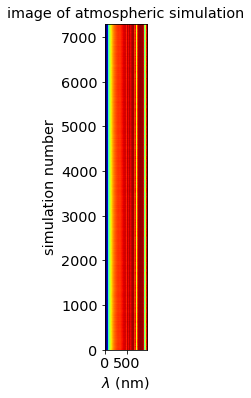

In [24]:
plt.imshow(transm,origin="lower",cmap='jet')
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("simulation number")
plt.title("image of atmospheric simulation")

# Output binary table

  col0 = fits.Column(name=names[0], format='D', array=index)
  
  col1 = fits.Column(name=names[1], format='D', array=x)
  
  col2 = fits.Column(name=names[2], format='D', array=y)

  ### Format into columns
  
  cols = fits.ColDefs([col0,col1, col2])


  ### Make the first HDU.
  
  hdu1 = fits.BinTableHDU.from_columns(cols)

  ### Concatenate all HDU
  ### Primary HDU - just a header
  
  hdr = fits.Header()
  
  hdr['OBSERVER'] = "JEC"
  
  hdr['COMMENT'] = "Pour debugger RP-DBSCAN"
  
  primary_hdu = fits.PrimaryHDU(header=hdr)

  hdul = fits.HDUList([primary_hdu, hdu1])

  ### Save on disk
  
  hdul.writeto("debug.fits",overwrite=True)


### Header columns

In [25]:
col1 = fits.Column(name='num', format='I', array=num)
col2 = fits.Column(name='year', format='I', array=year)
col3 = fits.Column(name='airmass', format='F', array=airmass)
col4 = fits.Column(name='vaod', format='F', array=vaod)
col5 = fits.Column(name='pwv', format='F', array=pwv)
col6 = fits.Column(name='o3', format='F', array=o3)
col7 = fits.Column(name='cld', format='F', array=cld)

In [26]:
col_headers=[col1, col2, col3, col4, col5, col6, col7]

### Data columns

In [27]:
col_data = []
idx=0
for thewl in wl:
    tagname = "wl{:04d}".format(int(thewl))
    col = fits.Column(name=tagname, format='F', array=transm[:,idx])
    col_data.append(col)
    if FLAG_FEWCOLUMNS and idx>20:
        break
    idx+=1

### All columns

In [28]:
col_all = col_headers + col_data

In [29]:
## Format into columns
cols = fits.ColDefs(col_all) 

In [30]:
hdu1 = fits.BinTableHDU.from_columns(cols)

## hdu and output file

In [31]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                  366                                                  
NBATMSIM=                  365                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [32]:
hdr['OBSERVER'] = "SDC"
hdr['COMMENT'] = "atm sim data challenge"

In [33]:
primary_hdu = fits.PrimaryHDU(header=hdr)

hdul = fits.HDUList([primary_hdu, hdu1])

In [34]:
#if FLAG_FEWCOLUMNS:
#    hdu1.writeto('lsst_atm_10year_bintab_small.fits',overwrite=True)
#else:
#    hdu1.writeto('lsst_atm_10year_bintab.fits',overwrite=True)

In [36]:
hdu1.to_pandas()

AttributeError: 'BinTableHDU' object has no attribute 'to_pandas'